In [1]:
import rebound
import sys
#change the next line to reflect where you have downloaded the source code
sys.path.insert(0, '/Users/kvolk/Documents/GitHub/SBDynT/src')
import sbdynt as sbd


# *Tools to directly set up a rebound integration from JPL orbit fits*
These routines use JPL's small body database to pull best-fit orbits and (if you want clones) an orbit-fit  covariance matrix for a small body given its designation and initializes a rebound simulation instance with that object and the sun and planets for the epoch of the orbit fit 

see detailed-examples-of-JPL-and-Horizons-query-functions.ipynb for details on the JPL queries

**Example of setting up an integration with clones for a single object**

Note that the rebound simulation will have the following units:

distance: au

time: years (1 year==365.25 days)

mass: solar masses

In [2]:
#Set up an empty simulation, specify the small body and number of clones
sim= rebound.Simulation()
#the designation of the small body can be given in most common formats, here we use packed provisional format
sbody = 'K14X40T'
#but one could also choose 
#sbody= '2014XT40' #unpacked prov. des without a space 
#sbody= '2014 XT40' #unpacked prov. des with a space
#sbody = '535167' #this object is also numbered
#sbody = 'r5167' #that number can be packed or not
clones = 5


#initialize the simulation with just the giant planets (can include all the major planets)
#if planets is omitted from the function call, Mercury-Neptune will be included
flag, epoch, sim = sbd.initialize_simulation(planets=['Jupiter','Saturn','Uranus','Neptune'],
                                                 des=sbody, clones=clones)
#the masses of planets not included in the call above are accounted for and added to the Sun
#the timestep of the simulation is set to a value reasonable for the closest-in included planet
#note that if you are simulating very close-in comets or near earth asteroids, you may need
#to reset that to a smaller value!

#print out the simulation status
if(flag):
    print("Sucessfully added ", sbody, "to a simulation at epoch ", epoch)
    print("the best fit clone has a heliocentric orbit of:")
    
    helio_orbit = sim.particles[sbody].calculate_orbit(sim.particles[0])
    print("a=",helio_orbit.a)
    print("e=",helio_orbit.e)
    print("i=",helio_orbit.inc)
    print("node=",helio_orbit.Omega)
    print("aperi=",helio_orbit.omega)
    print("mean anomaly=",helio_orbit.M)
    
    print("\n"+"or a barycentric orbit of:")
    
    helio_orbit = sim.particles[sbody].calculate_orbit(sim.calculate_com())
    print("a=",helio_orbit.a)
    print("e=",helio_orbit.e)
    print("i=",helio_orbit.inc)
    print("node=",helio_orbit.Omega)
    print("aperi=",helio_orbit.omega)
    print("mean anomaly=",helio_orbit.M)    
    
    
    sim.status(showAllFields=False)


Sucessfully added  K14X40T to a simulation at epoch  2457217.5
the best fit clone has a heliocentric orbit of:
a= 39.39493049938697
e= 0.19071028511960583
i= 0.12808954874296175
node= -2.3764739236986587
aperi= 3.0449200913389074
mean anomaly= 0.14957449159766867

or a barycentric orbit of:
a= 39.4060972335126
e= 0.19121388131996062
i= 0.1279988198070029
node= -2.3766713138417384
aperi= 3.033977870435759
mean anomaly= 0.15683745626851575
---------------------------------
REBOUND version:     	3.28.3
REBOUND built on:    	Oct  4 2023 16:27:39
Number of particles: 	11
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.400000
---------------------------------
<rebound.particle.Particle object at 0x28ea8f9d0, m=1.0000059769986274 x=0.0034610601623145097 y=0.00027631918524403633 z=-0.00015320621456877916 vx=0.0008681058230389303 vy=0.0023024789190979255 vz=-2.337071977160678e-05>
<rebound.particle.Particle object at 0x28eabb050, m=0.000954791909

You could proceed from here with regular rebound commands, but we have also included some tools
to directly run the rebound simulations, writing outputs to a simulation archive binary file

The simulation defaults to using rebound's mercurius integrator with for the timestep as set above based on the planets in the simulation. **Note that the simulation
does not check to see if a small body gets closer to the sun than the innermost included planet!!! This
means that the integration timestep might become unreasonable if the small body evolves too far inward.**
(Or you could be missing important perturbers, such as the terrestrial planets, if you initialized the 
simulation with only the outer planets! Check for such conditions when analyzing the output)

In [3]:
#max time in the integration (years)
tmax = 1e6

#how often you want to save the simulation archive file
tout = 1e3
savefile = "archive.bin"

#run the simulation, deleting any existing simulation archive
flag, sim = sbd.run_simulation(sim, tmax=tmax, tout=tout,filename=savefile,deletefile=True)

#if you want to use a whfast or ias15, you can specify that 
#flag, sim = sbd.run_simulation(sim, tmax=tmax, tout=tout,filename=savefile,deletefile=True,integrator='ias15')
#flag, sim = sbd.run_simulation(sim, tmax=tmax, tout=tout,filename=savefile,deletefile=True,integrator='whfast')

if(flag):
    print("Simulation ran to ", sim.t, " years")

Simulation ran to  1000000.0  years


**Example of setting up an integration with a list of small bodies**

(no clones allowed in this instance as the cloning procedure relies on orbit fits that have independent epochs!)



In [4]:
# Example of setting up an integration with a list of small bodies (no clones allowed)

#Set up an empty simulation, specify the small body and number of clones
sim= rebound.Simulation()
# as above, designations can be packed, unpacked, numbers, comets, etc
list_of_sbodies = ['K14X40T','2016 SW50', '15760','29P','179P/Jedicke']

#initialize the simulation without specifying planets (it will thus include all the major planets)
flag, epoch, sim = sbd.initialize_simulation_at_epoch(des=list_of_sbodies, epoch=2457019.)

#print out the simulation status
if(flag):
    sim.status(showAllFields=False)


---------------------------------
REBOUND version:     	3.28.3
REBOUND built on:    	Oct  4 2023 16:27:39
Number of particles: 	14
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.012000
---------------------------------
<rebound.particle.Particle object at 0x28ea8f9d0, m=1.0 x=0.002823131996485608 y=-0.0008788892248169295 z=-0.00013677120342035865 vx=0.0014620955720366165 vy=0.0019026198829254328 vz=-3.566762704994574e-05>
<rebound.particle.Particle object at 0x28ea8fed0, m=1.660120825450693e-07 x=0.2850152192904971 y=-0.3078755512113022 z=-0.051110918170975725 vx=5.526647147789773 vy=7.446690400192037 vz=0.10135077000098804>
<rebound.particle.Particle object at 0x28ea8f9d0, m=2.447838287784771e-06 x=0.4893659122545278 y=-0.5415398110768662 z=-0.0356247413395807 vx=5.444332334171796 vy=4.917084511306496 vz=-0.24677331732671584>
<rebound.particle.Particle object at 0x28ea8fed0, m=3.0404326489475004e-06 x=-0.09036731852085139 y=0.978147716

# **Example plots from the integration of K14X40T above**

There are two ways to read the simualtion archive file with the build in functions: by hash or by small body name (which will read in all the clones too if there are any)

In [5]:
#first by hash, where the best-fit always has the hash sbody and clones are sbody+"_j" for clones 1 through j
sbody = 'K14X40T'
savefile = 'archive.bin'
nclones=5
flag, abf, ebf, incbf, nodebf, aperibf, mabf, t = sbd.read_sa_by_hash(obj_hash = sbody, archivefile=savefile)

#you can read the planet evolution this way too, their hashes are their names in all lower case
#(though the routine will change your input to lowercase if you enter, e.g. "Jupiter")
flag, a_j, e_j, inc_j, node_j, aperi_j, ma_j, t = sbd.read_sa_by_hash(obj_hash = "jupiter", archivefile=savefile)

/Users/kvolk/anaconda3/envs/sbdynt/lib/python3.11/site-packages/rebound/simulationarchive.py:148: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


In [6]:
#now reading all the clones (the best fit will be indexed 0, then clones)
flag, a, e, inc, node, aperi, ma, t = sbd.read_sa_for_sbody(sbody=sbody, archivefile=savefile,nclones=nclones)

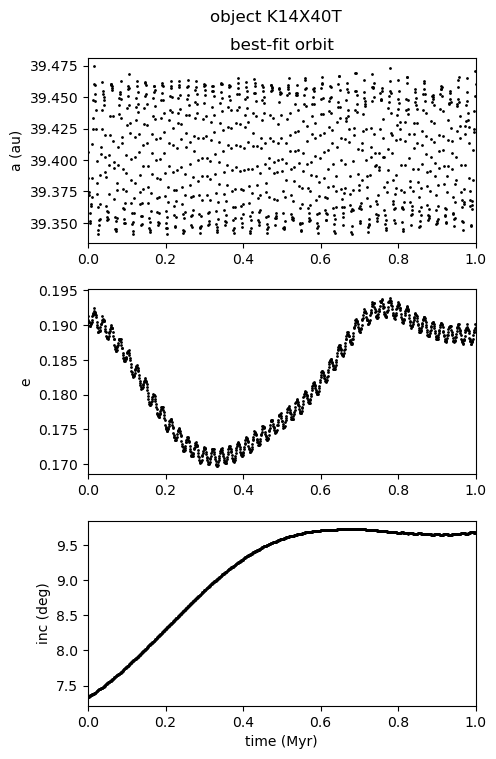

In [7]:
#plot just the best-fit orbit (no clones)
#figfile can be omitted if you don't want to save the figure
flag, fig = sbd.plot_aei(sbody=sbody,a=a,e=e,inc=inc,t=t,nclones=0,figfile='example-K14X40T-bf-aei.png')

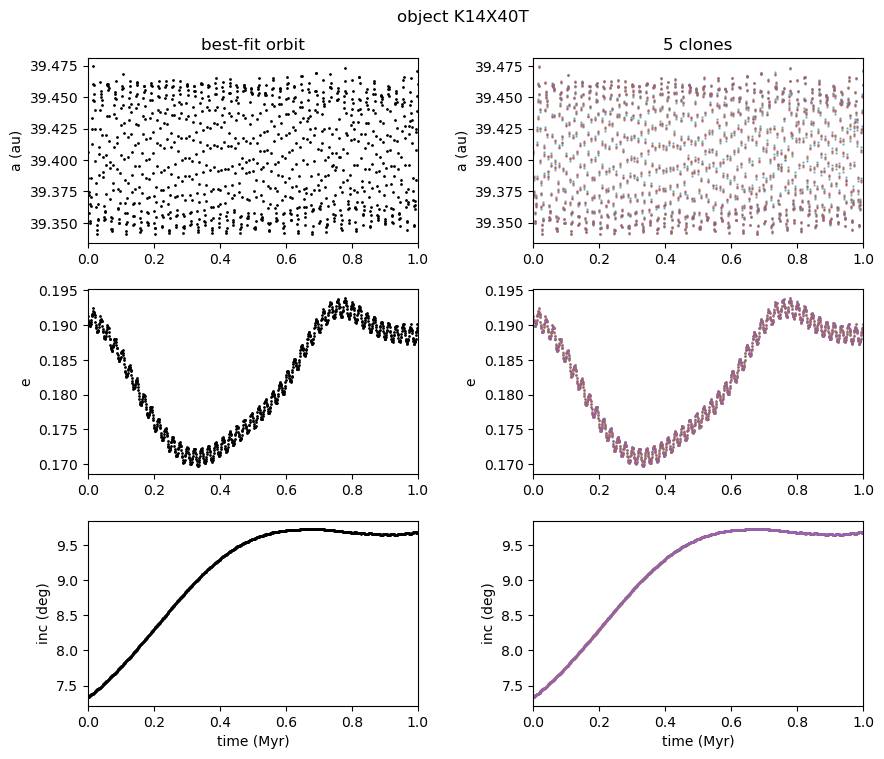

In [8]:
#make a two-column plot that also shows the clones
flag, fig2 = sbd.plot_aei(sbody=sbody,a=a,e=e,inc=inc,t=t,
                    nclones=nclones,figfile='example-K14X40T-bf-and-clones-aei.png')

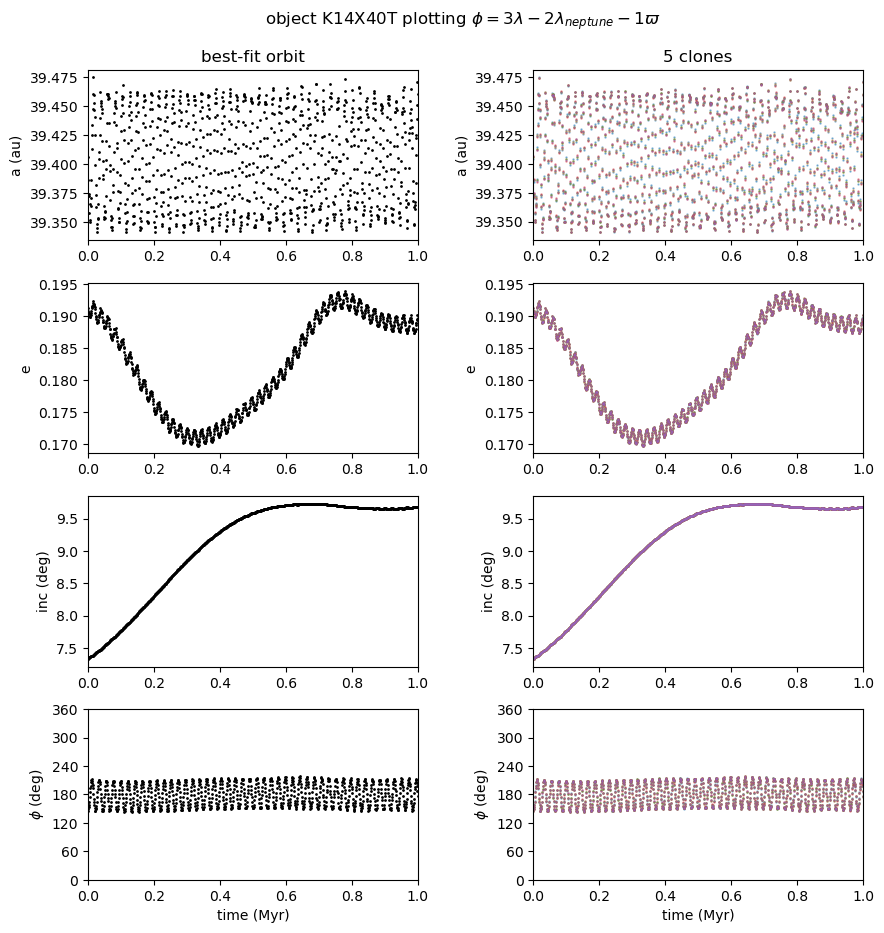

In [9]:
#this TNO happens to be a plutino, so you can also plot the resonant evolution
#first we go back to the simulation archive to calcaulte the resonant angle
#where for plutinos the p:q resonances is 3:2
(flag, a, e, inc, node, aperi, ma, phi, t,res_str) = sbd.read_sa_for_resonance(
                            sbody=sbody,
                            archivefile=savefile,planet='neptune',
                            p=3,q=2,nclones=nclones)
flag, fig3 = sbd.plot_resonance(sbody=sbody,
                          res_string=res_str,
                          a=a,e=e,inc=inc,phi=phi,t=t,
                          nclones=nclones,figfile=None)